### Setup

Update tensorflow datasets to use the new urls for datasets

In [240]:
!pip install -U tensorflow-datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [241]:
import os
import time
import glob

import numpy as np
import matplotlib.pyplot as plt
import PIL
from tqdm import trange

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

from IPython import display

## Load data

In [242]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
IMAGE_SIZE = (28, 28)
LATENT_DIM = 100
IS_MNIST = True
dataset = None

### Loading MNIST

In [243]:
if IS_MNIST:
  MAX_IMAGES_COUNT = 25000
  (images, labels), (_, _) = tf.keras.datasets.mnist.load_data()
  images = images.reshape(images.shape[0], 28, 28, 1).astype('float32')[:MAX_IMAGES_COUNT]
  images = (images - 127.5) / 127.5
  images = images.reshape(-1, IMAGE_SIZE[0]*IMAGE_SIZE[1]*1)
  dataset = tf.data.Dataset.from_tensor_slices(images).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
  print(f"Loaded ~{BATCH_SIZE*len(dataset)} Images.")

Loaded ~25088 Images.


### Loading Cats and Dogs

In [244]:
def image_resize(image, label):
  image = tf.image.rgb_to_grayscale(image)
  image = tf.image.resize(image, IMAGE_SIZE)
  image = tf.cast(image, tf.float32)/127.5-1.0
  image = image.reshape(-1, IMAGE_SIZE[0]*IMAGE_SIZE[1]*1)
  return image, label

In [245]:
if not IS_MNIST:
  dataset = tfds.load('cats_vs_dogs', split='train[:40%]', as_supervised=True, shuffle_files=True)
  dataset = dataset.map(image_resize, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
  print(f"Loaded ~{BATCH_SIZE*len(dataset)} Images.")

## Display Samples

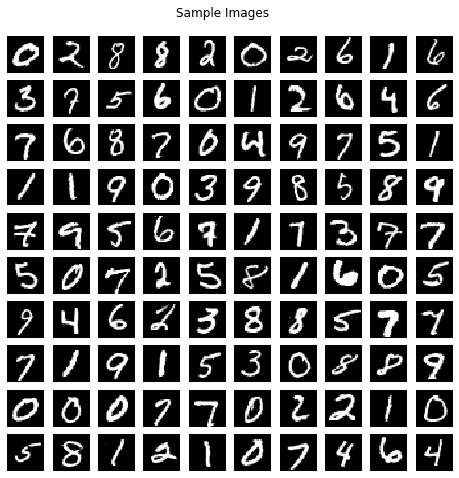

In [246]:
s = 0.6
n = 100
sqrtn = int(np.sqrt(n))
image_list = list(dataset.take(1))[0][:n] if IS_MNIST else list(dataset.take(1))[0][0][:n]

fig, axs = plt.subplots(sqrtn, sqrtn, figsize=(8,8), constrained_layout=False)
fig.suptitle("Sample Images", y=0.93)

for img, ax in zip(image_list, axs.ravel()):
  ax.axis("off")
  img += 1.0
  img *= 127.5
  img = img.numpy().squeeze().reshape(IMAGE_SIZE[0], IMAGE_SIZE[1])
  ax.imshow(img.astype(np.uint8), interpolation='nearest', cmap="gray")

## DCGAN Model

### Generator

In [247]:
def create_generator_model():
    generator = tf.keras.Sequential()
    
    generator.add(layers.Dense(256, input_dim=LATENT_DIM, use_bias=False))
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU(0.2))

    generator.add(layers.Dense(512, use_bias=False))
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU(0.2))

    generator.add(layers.Dense(1024, use_bias=False))
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU(0.2))

    generator.add(layers.Dense(IMAGE_SIZE[0]*IMAGE_SIZE[1]*1, use_bias=False, activation='tanh'))
    
    return generator

### Discriminator

In [248]:
def create_discriminator_model():
    discriminator = tf.keras.Sequential()
     
    discriminator.add(layers.Dense(1024, input_dim=IMAGE_SIZE[0]*IMAGE_SIZE[1]*1))
    discriminator.add(layers.LeakyReLU(0.2))

    discriminator.add(layers.Dense(512))
    discriminator.add(layers.LeakyReLU(0.2))
    discriminator.add(layers.Dropout(0.3))

    discriminator.add(layers.Dense(256))
    discriminator.add(layers.LeakyReLU(0.2))
    discriminator.add(layers.Dropout(0.3))

    discriminator.add(layers.Dense(1))
        
    return discriminator

### Create and predict an image using the untrained weights of the generator and discriminator

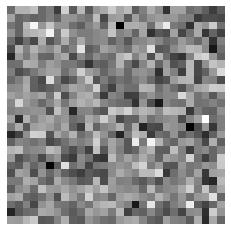

In [249]:
generator = create_generator_model()

noise = np.random.randn(1, LATENT_DIM)
generated_image = generator(noise, training=False)

plt.gca().set_axis_off()
plt.imshow(generated_image[0].numpy().reshape(IMAGE_SIZE[0], IMAGE_SIZE[1]), cmap='gray')
plt.show();

In [250]:
discriminator = create_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.08189347]], shape=(1, 1), dtype=float32)


In [251]:
generator.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_65 (Dense)            (None, 256)               25600     
                                                                 
 batch_normalization_9 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_48 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_66 (Dense)            (None, 512)               131072    
                                                                 
 batch_normalization_10 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_49 (LeakyReLU)  (None, 512)             

In [252]:
discriminator.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 1024)              803840    
                                                                 
 leaky_re_lu_51 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dense_70 (Dense)            (None, 512)               524800    
                                                                 
 leaky_re_lu_52 (LeakyReLU)  (None, 512)               0         
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_71 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_53 (LeakyReLU)  (None, 256)             

## Loss Functions

In [253]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

In [254]:
def discriminator_loss(real_output, fake_output):
  # Add small amount of noise to labels to help with training
  noise_real = 0.05 * tf.random.uniform(tf.shape(real_output))
  noise_fake = 0.05 * tf.random.uniform(tf.shape(fake_output))

  # real_loss = cross_entropy(tf.ones_like(real_output)+noise_real, real_output)
  # fake_loss = cross_entropy(tf.zeros_like(fake_output)+noise_fake, fake_output)
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  
  return total_loss

### Generator loss

In [255]:
def generator_loss(fake_output):
  # Add small amount of noise to labels to help with training
  noise_fake = 0.05 * tf.random.uniform(tf.shape(fake_output)) 

  
  # return cross_entropy(tf.ones_like(fake_output)+noise_fake, fake_output)
  return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [256]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)

### Save checkpoints
Set checkpoints for optimizers and the models

In [257]:
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Custom Training Loop


In [258]:
# @tf.function makes the function "compiled".
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  gen_loss = 0
  disc_loss = 0
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss

In [259]:
def train(dataset, epochs, debug=True):
  history = []
  for epoch in trange(epochs):
    start = time.time()
    epoch_gen_loss = 0
    epoch_disc_loss = 0
    
    for tuple_batch in dataset:
      if IS_MNIST:
        image_batch = tuple_batch
      else:
        image_batch, label_batch = tuple_batch

      # Calculate losses
      gen_loss, disc_loss = train_step(image_batch.numpy())
      epoch_gen_loss += gen_loss
      epoch_disc_loss += disc_loss

    # Normalize losses
    epoch_gen_loss /= BATCH_SIZE
    epoch_disc_loss /= BATCH_SIZE

    # Save loss history
    history.append((epoch_gen_loss, epoch_disc_loss))

    # Debug/info
    display.clear_output(wait=True)
    print(f"\nGen_loss:{epoch_gen_loss}, Disc_Loss:{epoch_disc_loss}")

    # Save the model every 10 epochs
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('\nTime for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Display a few samples from the current generator
    if debug:
      generate_and_save_images(generator,
                              epoch+1,
                              seed)

  # History is a 2 tuple consisting of generator_loss and discriminator_loss based on epoch number
  return history

## Generate and save images


In [260]:
def generate_and_save_images(model, epoch, test_input, n_images=100):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  sqrt_n_images = int(np.sqrt(n_images))

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(6, 6))
  fig.suptitle(f"Generator output at epoch {epoch}", y=0.93)
  
  for i in range(predictions.shape[0]):
    plt.subplot(sqrt_n_images, sqrt_n_images, i+1)
    plt.imshow(predictions[i].numpy().reshape(IMAGE_SIZE[0], IMAGE_SIZE[1]) * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Training

In [261]:
EPOCHS = 110
noise_dim = 100
num_examples_to_generate = 100 # 10 x 10 grid

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [262]:
# Comment if you want to continue training

#region create models
# generator = create_generator_model()
# discriminator = create_discriminator_model()

# generator_optimizer = tf.keras.optimizers.Adam(1e-4)
# discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                  discriminator_optimizer=discriminator_optimizer,
#                                  generator=generator,
#                                  discriminator=discriminator)
#endregion

In [263]:
history = train(dataset, EPOCHS, debug=False)

100%|██████████| 110/110 [01:20<00:00,  1.36it/s]


Gen_loss:1.3153150081634521, Disc_Loss:0.18624019622802734

Time for epoch 110 is 0.6691329479217529 sec


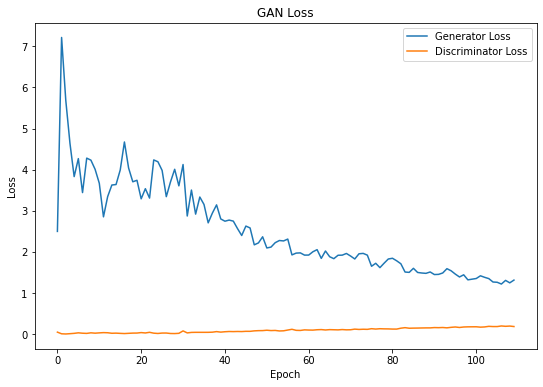

In [264]:
# history = [(1,1), (2,1)]
plt.figure(figsize=(9,6))
plt.title("GAN Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(np.arange(0, EPOCHS, 1), np.array(history)[:,0])
plt.plot(np.arange(0, EPOCHS, 1), np.array(history)[:,1])
plt.legend(["Generator Loss", "Discriminator Loss"])
plt.show()

Restore the latest checkpoint.

In [265]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate 100 Images

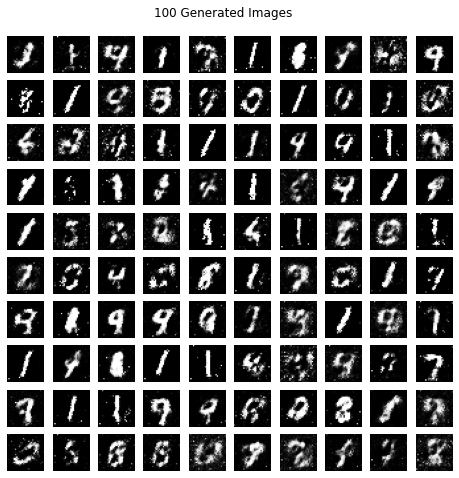

In [266]:
seed = tf.random.normal([100, noise_dim])

predictions = generator(seed, training=False)

fig = plt.figure(figsize=(8, 8))
fig.suptitle("100 Generated Images", y=0.93)

for i in range(predictions.shape[0]):
    plt.subplot(10, 10, i+1)
    plt.imshow(predictions[i].numpy().reshape(IMAGE_SIZE[0], IMAGE_SIZE[1]) * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

# plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
plt.show()